In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy import linalg as LA
%matplotlib inline

In [2]:
def Solve(W,Cd,Cl,Omega,rho,m,D,v0,coef_elasticity,mu):

    def f(V, t, params):
        x0,y0,z0,vx,vy,vz = V     
        V=np.array([vx,vy,vz])
        CD, CL, Rho,M,d,W,omega = params  # unpack  
        g=9.8            
        A=np.pi*d*d/4
        Vabs=V-W
        g=9.8
        derivs = [vx,vy,vz,-0.5*Rho*A*LA.norm(Vabs)*(CD*(vx-W[0])- CL*((omega[1]*(vz-W[2]) - omega[2]*(vy-W[1]))/LA.norm(omega))),      # list of dy/dt=f functions
             -0.5*rho*A*LA.norm(Vabs)*(CD*(vy-W[1])- CL*((omega[2]*(vx-W[0]) - omega[0]*(vz-W[2]))/LA.norm(omega))),-0.5*rho*A*LA.norm(Vabs)*((CD*(vz-W[2]))- CL*((omega[0]*(vy-W[1]) - omega[1]*(vx-W[0]))/LA.norm(omega)))-M*g]
        return derivs
    
    t1 = np.arange(0, 1.65, 0.05)
    
    # Bundle parameters for ODE solver
    params = [Cd, Cl, rho,m,D,W,Omega]
    from mpl_toolkits import mplot3d
    y0_1=v0
    psoln1 = odeint(f, v0, t1, args=(params,))
    a=int(1.65/0.05)
    print(a)
    print(psoln1.shape[0])
    if Omega[0] > 0:
        mul=-1
    else:
        mul=1
    y0_2=[psoln1[a,0],psoln1[a,1],psoln1[a,2],psoln1[a,3],psoln1[a,4]-mu*mul*psoln1[a,5]*(coef_elasticity+1),-coef_elasticity*psoln1[a,5]]
    print(psoln1[a,2])
    t2 = np.arange(1.65, 2.1, 0.05)
    
    #After impact with ground
    params = [Cd, Cl, rho,m,D,W,-Omega]
    psoln2 = odeint(f, y0_2, t2, args=(params,))
    ax1= plt.axes(projection='3d')
    ax1.set_ylim([1,2])
    ax1.plot3D(psoln1[:,0], psoln1[:,1],psoln1[:,2], 'gray')
    ax1.plot3D(psoln2[:,0], psoln2[:,1],psoln2[:,2], 'blue')
    
    fig = plt.figure(3, figsize=(8,8))

    # Plot x vs y
    ax2 = fig.add_subplot(311)
    ax2.plot(psoln1[:,0], psoln1[:,1])
    ax2.plot(psoln2[:,0], psoln2[:,1])
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_ylim([1.3,1.8])
    
    #plot x vs z
    ax3 = fig.add_subplot(312)
    ax3.plot(psoln1[:,0], psoln1[:,2])
    ax3.plot(psoln2[:,0], psoln2[:,2])
    ax3.set_xlabel('x')
    ax3.set_ylabel('z')
    ax3.set_ylim([0,2])
    
    Amount_of_spin=abs(psoln1[a,1]-psoln2[9,1])
    print("Amount of spin = ",Amount_of_spin)
    return 
    

32
33
0.023063453983582574
Amount of spin =  0.2856092245826609


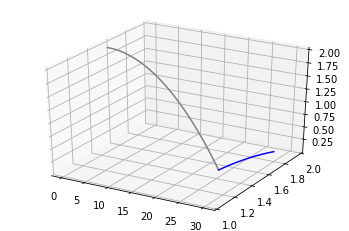

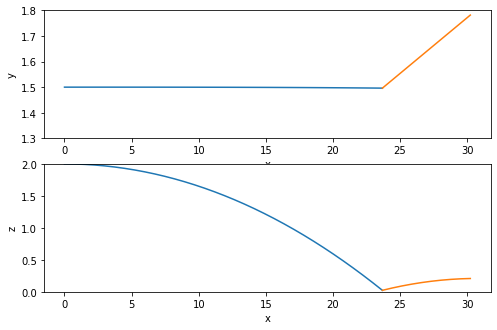

In [3]:
import math
W=np.array([0,0,0])
y0=[0,1.5,2,15,0,0]
Cd=0.45
Mu=0.2
omega=np.array([-150,0,0])
Cl=3.19*0.1*(1-np.exp(-2.48*0.001*LA.norm(omega)))
Coef_elasticity=0.31
rho=1.22
m=1.59*0.1
D=7.2*0.01
A=np.pi*D*D/4
Solve(W,Cd,Cl,omega,rho,m,D,y0,Coef_elasticity,Mu)
